# TechNova Partners - Analyse du Churn RH

**Projet :** Identification des causes de démission et modélisation prédictive  
**Client :** TechNova Partners (ESN spécialisée en transformation digitale)

---

## Contexte du Projet

TechNova Partners fait face à un turnover élevé. L'objectif est de :
1. **Analyser** les données RH pour identifier les différences entre employés partis et restés
2. **Construire** un modèle de classification pour prédire les démissions
3. **Extraire** les causes potentielles via l'interprétation du modèle (SHAP)

**Sources de données :**
- `data/extrait_sirh.csv` - Informations RH (âge, salaire, poste, ancienneté...)
- `data/extrait_eval.csv` - Évaluations de performance
- `data/extrait_sondage.csv` - Sondage employés + **variable cible**

---

## Structure du Notebook

**Partie 1 : Exploration des Données**
- Chargement et compréhension des fichiers
- Fusion et création du dataset central
- Analyse exploratoire et visualisations

**Partie 2 : Feature Engineering**
- Préparation des features (X)
- Encodage des variables catégorielles
- Gestion des corrélations

**Partie 3 : Modélisation Baseline**
- Modèle Dummy (référence)
- Modèle linéaire
- Modèle non-linéaire (arbre)

**Partie 4 : Gestion du Déséquilibre**
- Stratification
- Class weights / Undersampling / Oversampling (SMOTE)
- Calibration de probabilité
- Validation croisée stratifiée

**Partie 5 : Optimisation et Interpretation**
- Fine-tuning des hyperparamètres
- Feature importance globale (SHAP, Permutation)
- Feature importance locale (SHAP Waterfall)

---

---
## 1. Importation des librairies

In [389]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings  # noqa: E402

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.float_format", "{:.2f}".format)

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

warnings.filterwarnings("ignore")

---
## 2. Chargement des données

Chargement des 3 fichiers CSV et examen de structure.

In [390]:
df_sirh = pd.read_csv("data/extrait_sirh.csv")
df_eval = pd.read_csv("data/extrait_eval.csv")
df_sondage = pd.read_csv("data/extrait_sondage.csv")

print(f"Fichier SIRH : {df_sirh.shape[0]} lignes, {df_sirh.shape[1]} colonnes")
print(f"Fichier Évaluations : {df_eval.shape[0]} lignes, {df_eval.shape[1]} colonnes")
print(f"Fichier Sondage : {df_sondage.shape[0]} lignes, {df_sondage.shape[1]} colonnes")

Fichier SIRH : 1470 lignes, 12 colonnes
Fichier Évaluations : 1470 lignes, 10 colonnes
Fichier Sondage : 1470 lignes, 12 colonnes


---
## 3. Exploration initiale de chaque fichier

Avant de fusionner, comprenons le contenu et la structure de chaque fichier.

### 3.1 Fichier SIRH (extrait_sirh.csv)

#### Aperçu des premières lignes

Visualisons les premières lignes pour comprendre la structure et le contenu.

In [391]:
df_sirh.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2


#### Structure et types de données

Analysons les types de colonnes, la mémoire utilisée et les valeurs non-nulles.

In [392]:
df_sirh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id_employee                     1470 non-null   int64 
 1   age                             1470 non-null   int64 
 2   genre                           1470 non-null   object
 3   revenu_mensuel                  1470 non-null   int64 
 4   statut_marital                  1470 non-null   object
 5   departement                     1470 non-null   object
 6   poste                           1470 non-null   object
 7   nombre_experiences_precedentes  1470 non-null   int64 
 8   nombre_heures_travailless       1470 non-null   int64 
 9   annee_experience_totale         1470 non-null   int64 
 10  annees_dans_l_entreprise        1470 non-null   int64 
 11  annees_dans_le_poste_actuel     1470 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 137.9+ KB


#### Statistiques descriptives

Calculons les statistiques de base (moyenne, écart-type, min, max, quartiles) pour les variables numériques.

In [393]:
df_sirh.describe()

,id_employee,age,revenu_mensuel,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
count,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00
mean,1024.87,36.92,6502.93,2.69,80.00,11.28,7.01,4.23
std,602.02,9.14,4707.96,2.50,0.00,7.78,6.13,3.62
min,1.00,18.00,1009.00,0.00,80.00,0.00,0.00,0.00
25%,491.25,30.00,2911.00,1.00,80.00,6.00,3.00,2.00
50%,1020.50,36.00,4919.00,2.00,80.00,10.00,5.00,3.00
75%,1555.75,43.00,8379.00,4.00,80.00,15.00,9.00,7.00
max,2068.00,60.00,19999.00,9.00,80.00,40.00,40.00,18.00


#### Analyse des variables catégorielles

Examinons les valeurs uniques et leur fréquence pour chaque variable catégorielle.

In [394]:
print("Valeurs uniques des colonnes catégorielles SIRH :")
for col in df_sirh.select_dtypes(include="object").columns:
    print(f"\n{col}: {df_sirh[col].nunique()} valeurs uniques")
    print(df_sirh[col].value_counts())

Valeurs uniques des colonnes catégorielles SIRH :

genre: 2 valeurs uniques
genre
M    882
F    588
Name: count, dtype: int64

statut_marital: 3 valeurs uniques
statut_marital
Marié(e)       673
Célibataire    470
Divorcé(e)     327
Name: count, dtype: int64

departement: 3 valeurs uniques
departement
Consulting             961
Commercial             446
Ressources Humaines     63
Name: count, dtype: int64

poste: 9 valeurs uniques
poste
Cadre Commercial           326
Assistant de Direction     292
Consultant                 259
Tech Lead                  145
Manager                    131
Senior Manager             102
Représentant Commercial     83
Directeur Technique         80
Ressources Humaines         52
Name: count, dtype: int64


### 3.2 Fichier Évaluations (extrait_eval.csv)

#### Aperçu des premières lignes

In [395]:
df_eval.head()

,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,2,3,2,4,1,1,E_1,3,Oui,11 %
1,3,2,2,2,4,3,E_2,4,Non,23 %
2,4,2,1,3,2,3,E_4,3,Oui,15 %
3,4,3,1,3,3,3,E_5,3,Oui,11 %
4,1,3,1,2,4,3,E_7,3,Non,12 %


#### Structure et types de données

In [396]:
df_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   satisfaction_employee_environnement        1470 non-null   int64 
 1   note_evaluation_precedente                 1470 non-null   int64 
 2   niveau_hierarchique_poste                  1470 non-null   int64 
 3   satisfaction_employee_nature_travail       1470 non-null   int64 
 4   satisfaction_employee_equipe               1470 non-null   int64 
 5   satisfaction_employee_equilibre_pro_perso  1470 non-null   int64 
 6   eval_number                                1470 non-null   object
 7   note_evaluation_actuelle                   1470 non-null   int64 
 8   heure_supplementaires                      1470 non-null   object
 9   augementation_salaire_precedente           1470 non-null   object
dtypes: int64(7), object(3)
memory usage:

#### Statistiques descriptives

In [421]:
print("Statistiques descriptives Evaluations (variables numeriques) :")
df_eval.describe()

Statistiques descriptives Evaluations (variables numeriques) :


,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle
count,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00
mean,2.72,2.73,2.06,2.73,2.71,2.76,3.15
std,1.09,0.71,1.11,1.10,1.08,0.71,0.36
min,1.00,1.00,1.00,1.00,1.00,1.00,3.00
25%,2.00,2.00,1.00,2.00,2.00,2.00,3.00
50%,3.00,3.00,2.00,3.00,3.00,3.00,3.00
75%,4.00,3.00,3.00,4.00,4.00,3.00,3.00
max,4.00,4.00,5.00,4.00,4.00,4.00,4.00


#### Analyse des variables catégorielles

In [422]:
# Valeurs uniques des colonnes catégorielles
print("Valeurs uniques des colonnes catégorielles Evaluations :")
for col in df_eval.select_dtypes(include="object").columns:
    print(f"\n{col}: {df_eval[col].nunique()} valeurs uniques")
    print(df_eval[col].value_counts())

Valeurs uniques des colonnes catégorielles Evaluations :

eval_number: 1470 valeurs uniques
eval_number
E_1       1
E_2       1
E_4       1
E_5       1
E_7       1
         ..
E_2061    1
E_2062    1
E_2064    1
E_2065    1
E_2068    1
Name: count, Length: 1470, dtype: int64

heure_supplementaires: 2 valeurs uniques
heure_supplementaires
Non    1054
Oui     416
Name: count, dtype: int64

augementation_salaire_precedente: 15 valeurs uniques
augementation_salaire_precedente
11 %    210
13 %    209
14 %    201
12 %    198
15 %    101
18 %     89
17 %     82
16 %     78
19 %     76
22 %     56
20 %     55
21 %     48
23 %     28
24 %     21
25 %     18
Name: count, dtype: int64


### 3.3 Fichier Sondage (extrait_sondage.csv)

#### Aperçu des premières lignes

In [399]:
df_sondage.head()

,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0
3,Non,0,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0
4,Non,1,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2


#### Structure et types de données

In [400]:
df_sondage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   a_quitte_l_entreprise                1470 non-null   object
 1   nombre_participation_pee             1470 non-null   int64 
 2   nb_formations_suivies                1470 non-null   int64 
 3   nombre_employee_sous_responsabilite  1470 non-null   int64 
 4   code_sondage                         1470 non-null   int64 
 5   distance_domicile_travail            1470 non-null   int64 
 6   niveau_education                     1470 non-null   int64 
 7   domaine_etude                        1470 non-null   object
 8   ayant_enfants                        1470 non-null   object
 9   frequence_deplacement                1470 non-null   object
 10  annees_depuis_la_derniere_promotion  1470 non-null   int64 
 11  annes_sous_responsable_actuel        1470 n

#### Statistiques descriptives

In [401]:
df_sondage.describe()

,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
count,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00
mean,0.79,2.80,1.00,1024.87,9.19,2.91,2.19,4.12
std,0.85,1.29,0.00,602.02,8.11,1.02,3.22,3.57
min,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00
25%,0.00,2.00,1.00,491.25,2.00,2.00,0.00,2.00
50%,1.00,3.00,1.00,1020.50,7.00,3.00,1.00,3.00
75%,1.00,3.00,1.00,1555.75,14.00,4.00,3.00,7.00
max,3.00,6.00,1.00,2068.00,29.00,5.00,15.00,17.00


#### Analyse des variables catégorielles

In [402]:
for col in df_sondage.select_dtypes(include="object").columns:
    print(f"\n{col}: {df_sondage[col].nunique()} valeurs uniques")
    print(df_sondage[col].value_counts())


a_quitte_l_entreprise: 2 valeurs uniques
a_quitte_l_entreprise
Non    1233
Oui     237
Name: count, dtype: int64

domaine_etude: 6 valeurs uniques
domaine_etude
Infra & Cloud              606
Transformation Digitale    464
Marketing                  159
Entrepreunariat            132
Autre                       82
Ressources Humaines         27
Name: count, dtype: int64

ayant_enfants: 1 valeurs uniques
ayant_enfants
Y    1470
Name: count, dtype: int64

frequence_deplacement: 3 valeurs uniques
frequence_deplacement
Occasionnel    1043
Frequent        277
Aucun           150
Name: count, dtype: int64


---
## 4. Identification des clés de jointure

Pour fusionner les 3 fichiers, nous devons identifier les colonnes qui permettent de faire le lien entre eux.

#### Analyse des colonnes identifiantes

Examinons les colonnes qui nous permettront de faire les jointures entre fichiers.

In [403]:
print("Colonnes SIRH :")
print(df_sirh.columns.tolist())
print(
    f"\nClé potentielle 'id_employee' : {df_sirh['id_employee'].nunique()} valeurs uniques sur {len(df_sirh)} lignes"
)

print("\n" + "-" * 60)
print("\nColonnes Évaluations :")
print(df_eval.columns.tolist())
print(
    f"\nClé potentielle 'eval_number' : {df_eval['eval_number'].nunique()} valeurs uniques sur {len(df_eval)} lignes"
)

print("\n" + "-" * 60)
print("\nColonnes Sondage :")
print(df_sondage.columns.tolist())
print(
    f"\nClé potentielle 'code_sondage' : {df_sondage['code_sondage'].nunique()} valeurs uniques sur {len(df_sondage)} lignes"
)

Colonnes SIRH :
['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital', 'departement', 'poste', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel']

Clé potentielle 'id_employee' : 1470 valeurs uniques sur 1470 lignes

------------------------------------------------------------

Colonnes Évaluations :
['satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'eval_number', 'note_evaluation_actuelle', 'heure_supplementaires', 'augementation_salaire_precedente']

Clé potentielle 'eval_number' : 1470 valeurs uniques sur 1470 lignes

------------------------------------------------------------

Colonnes Sondage :
['a_quitte_l_entreprise', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite

In [404]:
# Analysons le format des clés pour comprendre comment les relier
print("Exemples de clés :")
print(f"\nSIRH - id_employee (premiers) : {df_sirh['id_employee'].head(10).tolist()}")
print(f"\nEval - eval_number (premiers) : {df_eval['eval_number'].head(10).tolist()}")
print(
    f"\nSondage - code_sondage (premiers) : {df_sondage['code_sondage'].head(10).tolist()}"
)

Exemples de clés :

SIRH - id_employee (premiers) : [1, 2, 4, 5, 7, 8, 10, 11, 12, 13]

Eval - eval_number (premiers) : ['E_1', 'E_2', 'E_4', 'E_5', 'E_7', 'E_8', 'E_10', 'E_11', 'E_12', 'E_13']

Sondage - code_sondage (premiers) : [1, 2, 4, 5, 7, 8, 10, 11, 12, 13]


#### Analyse du format des clés

Regardons de plus près comment sont structurées ces clés.

In [405]:
print("Comparaison du nombre de lignes :")
print(f"  - SIRH : {len(df_sirh)} lignes")
print(f"  - Évaluations : {len(df_eval)} lignes")
print(f"  - Sondage : {len(df_sondage)} lignes")

# Si tous les fichiers ont le même nombre de lignes,
# ils correspondent probablement aux mêmes employés

Comparaison du nombre de lignes :
  - SIRH : 1470 lignes
  - Évaluations : 1470 lignes
  - Sondage : 1470 lignes


#### Vérification de la cohérence des données

Comparons le nombre de lignes pour détecter d'éventuels problèmes.

In [406]:
print("Analyse de l'ordre et de la correspondance des lignes :\n")

# Hypothèse : si tous ont le même nombre de lignes dans le même ordre,
# les employés sont peut-être déjà alignés par index

# Vérifions s'il y a des colonnes communes
print("Colonnes communes entre les fichiers :")
sirh_cols = set(df_sirh.columns)
eval_cols = set(df_eval.columns)
sondage_cols = set(df_sondage.columns)

print(f"\nSIRH ∩ Évaluations : {sirh_cols.intersection(eval_cols)}")
print(f"SIRH ∩ Sondage : {sirh_cols.intersection(sondage_cols)}")
print(f"Évaluations ∩ Sondage : {eval_cols.intersection(sondage_cols)}")


Analyse de l'ordre et de la correspondance des lignes :

Colonnes communes entre les fichiers :

SIRH ∩ Évaluations : set()
SIRH ∩ Sondage : set()
Évaluations ∩ Sondage : set()


#### Conclusion : Fusion par index

**Résultat attendu :** Aucune colonne commune (set() vide partout).

**Pourquoi ?** Chaque fichier a des colonnes **uniques** :
- SIRH → infos administratives (id_employee, ancienneté, salaire...)
- Évaluations → métriques performance (eval_number, satisfaction_manager, note_autonomie...)
- Sondage → perception employé (code_sondage, equilibre_vie_pro_perso, niveau_stress...)

**Stratégie de fusion :** Comme les 3 fichiers ont le **même nombre de lignes (1470)** et que les indices correspondent (id_employee=1 ↔ eval_number="E_1" ↔ code_sondage=1), nous pouvons effectuer une **concaténation horizontale par index** avec `pd.concat(..., axis=1)`.

Aucune jointure SQL n'est nécessaire, Les lignes sont déjà alignées.

#### Recherche de colonnes communes

Vérifions s'il existe des colonnes partagées entre les fichiers.

In [407]:
# Analysons la structure des colonnes "clés"
print("Analyse détaillée des colonnes identifiantes :\n")

# SIRH
print("FICHIER SIRH - Colonne 'id_employee'")
print(f"Type de données : {df_sirh['id_employee'].dtype}")
print(f"Valeurs uniques : {df_sirh['id_employee'].nunique()}")
print(f"Total de lignes : {len(df_sirh)}")
print(f"Valeurs manquantes : {df_sirh['id_employee'].isna().sum()}")
print(f"Doublons : {df_sirh['id_employee'].duplicated().sum()}")
print(f"\nExemples : {df_sirh['id_employee'].head(5).tolist()}")

# Évaluations
print("FICHIER ÉVALUATIONS - Colonne 'eval_number'")
print(f"Type de données : {df_eval['eval_number'].dtype}")
print(f"Valeurs uniques : {df_eval['eval_number'].nunique()}")
print(f"Total de lignes : {len(df_eval)}")
print(f"Valeurs manquantes : {df_eval['eval_number'].isna().sum()}")
print(f"Doublons : {df_eval['eval_number'].duplicated().sum()}")
print(f"\nExemples : {df_eval['eval_number'].head(5).tolist()}")

# Sondage
print("FICHIER SONDAGE - Colonne 'code_sondage'")
print(f"Type de données : {df_sondage['code_sondage'].dtype}")
print(f"Valeurs uniques : {df_sondage['code_sondage'].nunique()}")
print(f"Total de lignes : {len(df_sondage)}")
print(f"Valeurs manquantes : {df_sondage['code_sondage'].isna().sum()}")
print(f"Doublons : {df_sondage['code_sondage'].duplicated().sum()}")
print(f"\nExemples : {df_sondage['code_sondage'].head(5).tolist()}")

Analyse détaillée des colonnes identifiantes :

FICHIER SIRH - Colonne 'id_employee'
Type de données : int64
Valeurs uniques : 1470
Total de lignes : 1470
Valeurs manquantes : 0
Doublons : 0

Exemples : [1, 2, 4, 5, 7]
FICHIER ÉVALUATIONS - Colonne 'eval_number'
Type de données : object
Valeurs uniques : 1470
Total de lignes : 1470
Valeurs manquantes : 0
Doublons : 0

Exemples : ['E_1', 'E_2', 'E_4', 'E_5', 'E_7']
FICHIER SONDAGE - Colonne 'code_sondage'
Type de données : int64
Valeurs uniques : 1470
Total de lignes : 1470
Valeurs manquantes : 0
Doublons : 0

Exemples : [1, 2, 4, 5, 7]


#### Analyse détaillée des clés de jointure

Explorons en détail chaque colonne identifiante pour comprendre leur structure.

In [408]:
# Vérifions si les clés peuvent être liées entre elles
print("Recherche de correspondances potentielles entre les clés :\n")

# Testons si une partie de la clé correspond entre fichiers
# Par exemple, si id_employee = "EMP_001" et eval_number contient "001"

print("Premières valeurs de chaque clé pour comparaison visuelle :")
comparison_df = pd.DataFrame(
    {
        "id_employee": df_sirh["id_employee"].head(10),
        "eval_number": df_eval["eval_number"].head(10),
        "code_sondage": df_sondage["code_sondage"].head(10),
    }
)
comparison_df

Recherche de correspondances potentielles entre les clés :

Premières valeurs de chaque clé pour comparaison visuelle :


,id_employee,eval_number,code_sondage
0,1,E_1,1
1,2,E_2,2
2,4,E_4,4
3,5,E_5,5
4,7,E_7,7
5,8,E_8,8
6,10,E_10,10
7,11,E_11,11
8,12,E_12,12
9,13,E_13,13


---
## 5. Fusion des données

Les 3 fichiers ont le même nombre de lignes (1470) et les clés correspondent (id_employee = code_sondage, eval_number = "E_" + id).
Nous allons les fusionner par concaténation horizontale.

#### Création du DataFrame central

Fusion des 3 fichiers par concaténation horizontale (axis=1).

In [409]:
df_merged = pd.concat([df_sirh, df_eval, df_sondage], axis=1)

print("DataFrame fusionné créé :")
print(f"  - {df_merged.shape[0]} lignes")
print(f"  - {df_merged.shape[1]} colonnes")
print(f"\nColonnes : {df_merged.columns.tolist()}")

DataFrame fusionné créé :
  - 1470 lignes
  - 34 colonnes

Colonnes : ['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital', 'departement', 'poste', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'eval_number', 'note_evaluation_actuelle', 'heure_supplementaires', 'augementation_salaire_precedente', 'a_quitte_l_entreprise', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'code_sondage', 'distance_domicile_travail', 'niveau_education', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel']


#### Gestion des colonnes dupliquées

Vérification et suppression des éventuelles colonnes en double.

In [410]:
# Vérification des colonnes dupliquées
duplicated_cols = df_merged.columns[df_merged.columns.duplicated()].tolist()

if duplicated_cols:
    print(f"{len(duplicated_cols)} colonne(s) dupliquée(s) détectée(s) :")
    for col in duplicated_cols:
        print(f"  - {col}")

    # Suppression des doublons (on garde la première occurrence)
    df_merged = df_merged.loc[:, ~df_merged.columns.duplicated()]
    print("\nColonnes dupliquées supprimées")
    print(f"Nouvelles dimensions : {df_merged.shape}")
else:
    print("Aucune colonne dupliquée détectée")

Aucune colonne dupliquée détectée


#### Aperçu du DataFrame central

Visualisation des premières lignes du dataset fusionné.

In [411]:
df_merged.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4,2,3,2,4,1,1,E_1,3,Oui,11 %,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7,3,2,2,2,4,3,E_2,4,Non,23 %,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0,4,2,1,3,2,3,E_4,3,Oui,15 %,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7,4,3,1,3,3,3,E_5,3,Oui,11 %,Non,0,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2,1,3,1,2,4,3,E_7,3,Non,12 %,Non,1,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2


#### Structure du DataFrame fusionné

Informations sur les types de données et la mémoire.

In [412]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 34 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   id_employee                                1470 non-null   int64 
 1   age                                        1470 non-null   int64 
 2   genre                                      1470 non-null   object
 3   revenu_mensuel                             1470 non-null   int64 
 4   statut_marital                             1470 non-null   object
 5   departement                                1470 non-null   object
 6   poste                                      1470 non-null   object
 7   nombre_experiences_precedentes             1470 non-null   int64 
 8   nombre_heures_travailless                  1470 non-null   int64 
 9   annee_experience_totale                    1470 non-null   int64 
 10  annees_dans_l_entreprise            

#### Analyse de la variable cible

Distribution de `a_quitte_l_entreprise` - la variable à prédire.

Variable cible - 'a_quitte_l_entreprise' :
Type : object

Distribution :
a_quitte_l_entreprise
Non    1233
Oui     237
Name: count, dtype: int64

Proportions (%) :
a_quitte_l_entreprise
Non   83.88
Oui   16.12
Name: proportion, dtype: float64


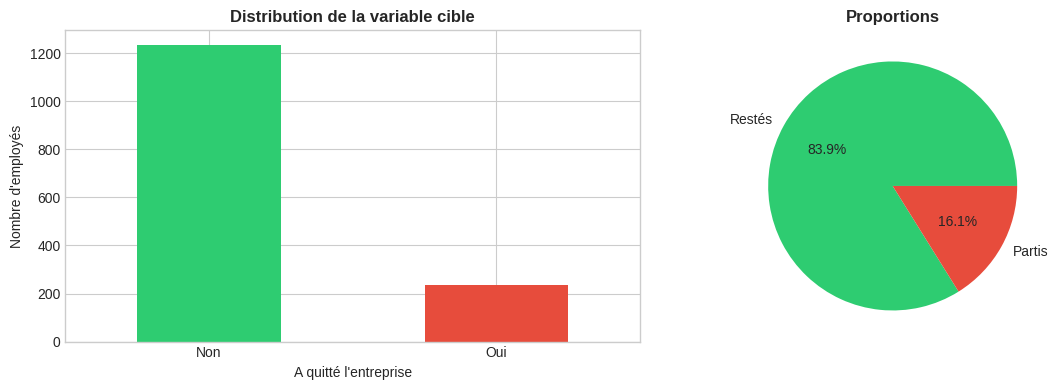

OBSERVATION CRITIQUE : Déséquilibre des classes !
     → À gérer en modélisation (stratification, class_weights, SMOTE)


In [413]:
print("Variable cible - 'a_quitte_l_entreprise' :")
print(f"Type : {df_merged['a_quitte_l_entreprise'].dtype}")
print("\nDistribution :")
print(df_merged["a_quitte_l_entreprise"].value_counts())
print("\nProportions (%) :")
print((df_merged["a_quitte_l_entreprise"].value_counts(normalize=True) * 100).round(2))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Comptage
df_merged["a_quitte_l_entreprise"].value_counts().plot(
    kind="bar", ax=ax[0], color=["#2ecc71", "#e74c3c"]
)
ax[0].set_title("Distribution de la variable cible", fontsize=12, fontweight="bold")
ax[0].set_xlabel("A quitté l'entreprise")
ax[0].set_ylabel("Nombre d'employés")
ax[0].set_xticklabels(["Non", "Oui"], rotation=0)

# Proportions
df_merged["a_quitte_l_entreprise"].value_counts().plot(
    kind="pie",
    ax=ax[1],
    autopct="%1.1f%%",
    colors=["#2ecc71", "#e74c3c"],
    labels=["Restés", "Partis"],
)
ax[1].set_title("Proportions", fontsize=12, fontweight="bold")
ax[1].set_ylabel("")

plt.tight_layout()
plt.show()

print("OBSERVATION CRITIQUE : Déséquilibre des classes !")
print("     → À gérer en modélisation (stratification, class_weights, SMOTE)")


#### Synthèse : Variable cible

- **84% restés** vs **16% partis** → Ratio 5:1
- Déséquilibre à gérer : stratification, class_weight, resampling, calibration
- Accuracy insuffisante comme métrique (84% sans rien faire)

---
## 6. Vue d'ensemble du dataset central

Avant de comparer les employés partis vs restés, vérifions la qualité et la structure des données :
- Valeurs manquantes
- Types de colonnes (numériques vs catégorielles)
- Colonnes identifiantes à exclure de l'analyse

#### Analyse des valeurs manquantes

Vérifions s'il y a des données manquantes dans le dataset fusionné.

In [414]:
# Analyse des valeurs manquantes
print("Analyse des valeurs manquantes :\n")

missing_values = df_merged.isnull().sum()
missing_pct = (df_merged.isnull().sum() / len(df_merged) * 100).round(2)

missing_df = pd.DataFrame(
    {"Valeurs manquantes": missing_values, "Pourcentage (%)": missing_pct}
)

# Afficher seulement les colonnes avec des valeurs manquantes
missing_with_values = missing_df[missing_df["Valeurs manquantes"] > 0]

if len(missing_with_values) > 0:
    print(f"{len(missing_with_values)} colonne(s) avec des valeurs manquantes :")
    print(missing_with_values.sort_values("Pourcentage (%)", ascending=False))
else:
    print("Aucune valeur manquante dans le dataset !")
    print(f"   → {df_merged.shape[0]} lignes × {df_merged.shape[1]} colonnes complètes")

Analyse des valeurs manquantes :

Aucune valeur manquante dans le dataset !
   → 1470 lignes × 34 colonnes complètes


#### Classification des colonnes par type

Identifions les colonnes numériques et catégorielles pour orienter l'analyse exploratoire.

In [415]:
print("Classification des colonnes par type :\n")

# Colonnes identifiantes (à exclure de l'analyse)
id_cols = ["id_employee", "eval_number", "code_sondage"]

# Variable cible
target_col = "a_quitte_l_entreprise"

# Colonnes numériques (excluant les IDs)
numeric_cols = df_merged.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in id_cols + [target_col]]

# Colonnes catégorielles
categorical_cols = df_merged.select_dtypes(include=["object"]).columns.tolist()
categorical_cols = [
    col for col in categorical_cols if col not in id_cols + [target_col]
]

print(f"Colonnes identifiantes ({len(id_cols)}) - À EXCLURE :")
print(f"   {id_cols}\n")

print("Variable cible :")
print(f"   {target_col}\n")

print(f"Colonnes numériques ({len(numeric_cols)}) :")
print(f"   {numeric_cols}\n")

print(f"Colonnes catégorielles ({len(categorical_cols)}) :")
print(f"   {categorical_cols}")

print(f"Total features analysables : {len(numeric_cols) + len(categorical_cols)}")

Classification des colonnes par type :

Colonnes identifiantes (3) - À EXCLURE :
   ['id_employee', 'eval_number', 'code_sondage']

Variable cible :
   a_quitte_l_entreprise

Colonnes numériques (21) :
   ['age', 'revenu_mensuel', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'distance_domicile_travail', 'niveau_education', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel']

Colonnes catégorielles (9) :
   ['genre', 'statut_marital', 'departement', 'poste', 'heure_supplementaires', 'augementation_salaire_precedente', 'domaine_etude', '

#### Résumé structuré du dataset

Tableau récapitulatif avec le type, les valeurs uniques et des exemples pour chaque colonne.

In [416]:
summary_data = []

for col in df_merged.columns:
    if col in id_cols:
        category = "Identifiant"
    elif col == target_col:
        category = "Cible"
    elif col in numeric_cols:
        category = "Numérique"
    else:
        category = "Catégorielle"

    summary_data.append(
        {
            "Colonne": col,
            "Catégorie": category,
            "Type": str(df_merged[col].dtype),
            "Valeurs uniques": df_merged[col].nunique(),
            "Exemple": str(df_merged[col].iloc[0])[:30],
        }
    )

summary_df = pd.DataFrame(summary_data)
summary_df

,Colonne,Catégorie,Type,Valeurs uniques,Exemple
0,id_employee,Identifiant,int64,1470,1
1,age,Numérique,int64,43,41
2,genre,Catégorielle,object,2,F
3,revenu_mensuel,Numérique,int64,1349,5993
4,statut_marital,Catégorielle,object,3,Célibataire
5,departement,Catégorielle,object,3,Commercial
6,poste,Catégorielle,object,9,Cadre Commercial
7,nombre_experiences_precedentes,Numérique,int64,10,8
8,nombre_heures_travailless,Numérique,int64,1,80
9,annee_experience_totale,Numérique,int64,40,8


---
## 7. Analyse exploratoire comparative : Partis vs Restés

Objectif principal de cette section : **identifier les différences clés** entre les employés ayant quitté l'entreprise et ceux qui y sont restés.

Nous utiliserons **Plotly** pour des graphiques interactifs.

#### Import de Plotly et préparation des données

Configuration de Plotly et création d'une colonne lisible pour la variable cible.

In [417]:
import plotly.express as px

df_merged["statut"] = df_merged["a_quitte_l_entreprise"].map(
    {"Oui": "Parti", "Non": "Resté"}
)

colors = {"Resté": "#2ecc71", "Parti": "#e74c3c"}

print(f"   Distribution : {df_merged['statut'].value_counts().to_dict()}")

   Distribution : {'Resté': 1233, 'Parti': 237}


### 7.1 Analyse des variables numériques

Comparons les **moyennes** des variables numériques entre les employés partis et restés avec un graphique unique et lisible.

#### Différences relatives des moyennes (Partis vs Restés)

Un seul graphique montrant la différence en pourcentage pour chaque variable. Plus facile à interpréter que des boxplots multiples !

In [418]:
# Calcul des moyennes par statut
means_parti = df_merged[df_merged["statut"] == "Parti"][numeric_cols].mean()
means_reste = df_merged[df_merged["statut"] == "Resté"][numeric_cols].mean()

# Calcul de la différence relative en %
diff_pct = ((means_parti - means_reste) / means_reste * 100).round(1)

# Créer le DataFrame pour le graphique
diff_df = pd.DataFrame(
    {"Variable": diff_pct.index, "Différence (%)": diff_pct.values}
).sort_values("Différence (%)", key=abs, ascending=True)

fig = px.bar(
    diff_df,
    x="Différence (%)",
    y="Variable",
    orientation="h",
    title="Différence relative des moyennes : Partis vs Restés",
    color="Différence (%)",
    color_continuous_scale=["#e74c3c", "#f5f5f5", "#2ecc71"],
    color_continuous_midpoint=0,
)

fig.add_vline(x=0, line_color="black", line_width=2)
fig.update_layout(
    height=600,
    xaxis_title="Différence relative (%)",
    yaxis_title="",
    coloraxis_colorbar_title="Diff (%)",
)

fig.show()

print("\nLecture du graphique :")
print("   • Barres ROUGES (négatives) → Partis ont des valeurs PLUS BASSES")
print("   • Barres VERTES (positives) → Partis ont des valeurs PLUS HAUTES")


Lecture du graphique :
   • Barres ROUGES (négatives) → Partis ont des valeurs PLUS BASSES
   • Barres VERTES (positives) → Partis ont des valeurs PLUS HAUTES


#### Comment lire ce graphique ?

Chaque barre montre **de combien de %** les employés qui partent diffèrent de ceux qui restent **pour cette variable**.

| Variable | Diff | Signification concrète |
|----------|------|------------------------|
| `revenu_mensuel` | -29.9% | Ceux qui partent gagnent **moins d'argent** |
| `annees_dans_l_entreprise` | -30.4% | Ceux qui partent ont **moins d'années** d'ancienneté |
| `distance_domicile_travail` | +19.3% | Ceux qui partent habitent à **plus de kilomètres** |

**En résumé :**
- Barre rouge (négative) : Ceux qui partent ont une valeur **plus basse** pour cette variable
- Barre verte (positive) : Ceux qui partent ont une valeur **plus haute** pour cette variable
- Proche de 0 : Pas de différence entre les deux groupes

#### Observations : Variables numériques

**Principales différences observées :**

| Variable | Différence | Observation |
|----------|------------|-------------|
| `nombre_participation_pee` | -37.6% | Participation PEE plus faible |
| `annees_dans_le_poste_actuel` | -35.3% | Ancienneté dans le poste plus faible |
| `revenu_mensuel` | -29.9% | Salaire plus bas |
| `distance_domicile_travail` | +19.3% | Distance plus grande |

**Note :** Ce sont des observations descriptives. Le modèle confirmera l'importance réelle de chaque variable.

#### Tableau récapitulatif des statistiques

Détail des moyennes et médianes pour chaque groupe.

In [419]:
# Tableau récapitulatif plus robuste
stats_parti = df_merged[df_merged["statut"] == "Parti"][numeric_cols].agg(
    ["mean", "median"]
)
stats_reste = df_merged[df_merged["statut"] == "Resté"][numeric_cols].agg(
    ["mean", "median"]
)

comparison_stats = pd.DataFrame(
    {
        "Parti_moyenne": stats_parti.loc["mean"],
        "Parti_médiane": stats_parti.loc["median"],
        "Resté_moyenne": stats_reste.loc["mean"],
        "Resté_médiane": stats_reste.loc["median"],
    }
)

# Calculer la différence relative
comparison_stats["Diff_%"] = (
    (comparison_stats["Parti_moyenne"] - comparison_stats["Resté_moyenne"])
    / comparison_stats["Resté_moyenne"]
    * 100
).round(1)

# Trier par différence absolue
comparison_stats = comparison_stats.sort_values("Diff_%", key=abs, ascending=False)

print("Statistiques comparatives (triées par |différence|) :\n")
comparison_stats.round(2)

Statistiques comparatives (triées par |différence|) :



,Parti_moyenne,Parti_médiane,Resté_moyenne,Resté_médiane,Diff_%
nombre_participation_pee,0.53,0.00,0.85,1.00,-37.60
annees_dans_le_poste_actuel,2.90,2.00,4.48,3.00,-35.30
annes_sous_responsable_actuel,2.85,2.00,4.37,3.00,-34.70
annee_experience_totale,8.24,7.00,11.86,10.00,-30.50
annees_dans_l_entreprise,5.13,3.00,7.37,6.00,-30.40
revenu_mensuel,4787.09,3202.00,6832.74,5204.00,-29.90
niveau_hierarchique_poste,1.64,1.00,2.15,2.00,-23.70
distance_domicile_travail,10.63,9.00,8.92,7.00,19.30
annees_depuis_la_derniere_promotion,1.95,1.00,2.23,1.00,-12.90
nombre_experiences_precedentes,2.94,1.00,2.65,2.00,11.20


### 7.2 Analyse des variables catégorielles

Visualisons le taux de churn pour chaque modalité de toutes les variables catégorielles.

#### Taux de churn par modalité

Graphique en barres horizontales montrant le taux de départ pour chaque modalité. La ligne rouge = taux moyen global (~16%).

In [423]:
# Calcul du taux de churn pour chaque modalité de chaque variable catégorielle
churn_data = []

for col in categorical_cols:
    for modalite in df_merged[col].unique():
        subset = df_merged[df_merged[col] == modalite]
        taux = (subset["a_quitte_l_entreprise"] == "Oui").mean() * 100
        effectif = len(subset)
        churn_data.append(
            {
                "Variable": col,
                "Modalité": str(modalite),
                "Taux_churn_%": round(taux, 1),
                "Effectif": effectif,
            }
        )

churn_df = pd.DataFrame(churn_data)

# Trier par taux de churn décroissant
churn_df = churn_df.sort_values("Taux_churn_%", ascending=True)

# Créer un label combiné pour l'axe Y
churn_df["Label"] = churn_df["Variable"] + " : " + churn_df["Modalité"]

# Taux global pour référence
taux_global = (df_merged["a_quitte_l_entreprise"] == "Oui").mean() * 100

# Graphique unique
fig = px.bar(
    churn_df,
    x="Taux_churn_%",
    y="Label",
    orientation="h",
    title="Taux de churn par modalité (toutes variables catégorielles)",
    color="Taux_churn_%",
    color_continuous_scale=["#2ecc71", "#f39c12", "#e74c3c"],
    hover_data=["Variable", "Modalité", "Effectif"],
    labels={"Taux_churn_%": "Taux de churn (%)", "Label": ""},
)

# Ligne de référence (taux global)
fig.add_vline(
    x=taux_global,
    line_dash="dash",
    line_color="red",
    line_width=2,
    annotation_text=f"Moyenne: {taux_global:.1f}%",
    annotation_position="top",
)

fig.update_layout(
    height=max(600, len(churn_df) * 25),
    xaxis_title="Taux de churn (%)",
    yaxis_title="",
    showlegend=False,
)

fig.show()

print(
    "\nLecture : Les barres a DROITE de la ligne rouge ont un taux de churn SUPERIEUR a la moyenne."
)


Lecture : Les barres a DROITE de la ligne rouge ont un taux de churn SUPERIEUR a la moyenne.


#### Observations : Variables catégorielles

**Taux de churn élevé :** Représentant Commercial (39.8%), heures sup Oui (30.5%), Célibataire (25.5%)

**Taux de churn faible :** Directeur Technique (2.5%), Manager (6.9%), heures sup Non (10.4%)

**Facteurs à explorer :** heures sup, poste, statut marital, déplacements.

---
### 7.3 Observations préliminaires

**Variables à explorer dans le modèle :**
- Numériques : `nombre_participation_pee`, `annees_dans_le_poste_actuel`, `revenu_mensuel`
- Catégorielles : `heure_supplementaires`, `poste`, `statut_marital`

**Attention :** 
- Déséquilibre 84%/16% : stratification + gestion du déséquilibre nécessaire
- Ces observations sont **descriptives** : le modèle validera quelles variables sont réellement prédictives